# Clustering - Unsupervised Learning

## Setup

In [126]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Classification _vs_ Clustering

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering


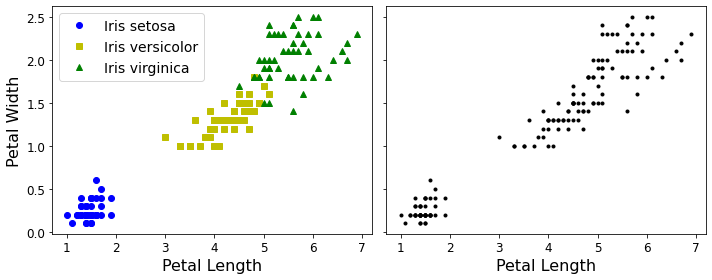

In [4]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(X[:, 2][y==0], X[:, 3][y==0], 'bo', label='Iris setosa')
plt.plot(X[:, 2][y==1], X[:, 3][y==1], 'ys', label='Iris versicolor')
plt.plot(X[:, 2][y==2], X[:, 3][y==2], 'g^', label='Iris virginica')
plt.xlabel('Petal Length', fontsize=16)
plt.ylabel('Petal Width', fontsize=16)
plt.legend(loc='upper left', fontsize=14)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c='k', marker='.')
plt.xlabel('Petal Length', fontsize=16)
plt.tick_params(labelleft=False)

save_fig('classification_vs_clustering')
plt.show()

A Gaussian mixture model can actually separate these clusters pretty well

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping, we will pick the most common class for each cluster(using `scipy.stats.mode()` function):

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id
mapping

{1: 0, 2: 1, 0: 2}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

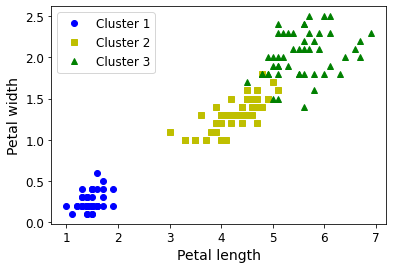

In [9]:
plt.plot(X[:, 2][y==0], X[:, 3][y==0], 'bo', label='Cluster 1')
plt.plot(X[:, 2][y==1], X[:, 3][y==1], 'ys', label='Cluster 2')
plt.plot(X[:, 2][y==2], X[:, 3][y==2], 'g^', label='Cluster 3')
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
np.sum(y_pred==y)

145

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

## K-Means

Let's start by generating blobs:

In [12]:
from sklearn.datasets import make_blobs

In [13]:
blob_centers = np.array(
    [[0.2,  2.3],
     [-1.5, 2.3],
     [-2.5, 2],
     [-2.8,  2.8],
     [-2.8,  1.3]
    ])
blob_std = np.array([0.4, 0.3, 0.2, 0.1, 0.1])

In [14]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                 cluster_std=blob_std, random_state=7)

Now let's plot them:

In [15]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16, rotation=0)

Saving figure blobs_plot


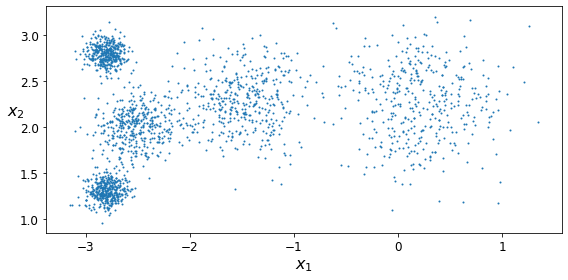

In [16]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig('blobs_plot')
plt.show()

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [17]:
from sklearn.cluster import KMeans

In [18]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the five clusters:

In [19]:
y_pred

array([2, 4, 1, ..., 0, 1, 4], dtype=int32)

In [20]:
kmeans.labels_

array([2, 4, 1, ..., 0, 1, 4], dtype=int32)

In [21]:
y_pred in kmeans.labels_

True

The following 5 centroids (i.e. cluster centers) were estimated:

In [22]:
kmeans.cluster_centers_

array([[-2.79487422,  2.79477111],
       [ 0.21087045,  2.25606987],
       [-2.7945391 ,  1.31684652],
       [-1.44513285,  2.29169742],
       [-2.48338211,  2.02347675]])

In [23]:
blob_centers

array([[ 0.2,  2.3],
       [-1.5,  2.3],
       [-2.5,  2. ],
       [-2.8,  2.8],
       [-2.8,  1.3]])

Predicting the labels of new instances: 

In [24]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-1, 2]])
kmeans.predict(X_new)


array([1, 1, 0, 3], dtype=int32)

### Decision Boundries

Let's plot the model's decision boundries. This gives us a _Voronoi_ diagram:

In [25]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                            show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                        np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


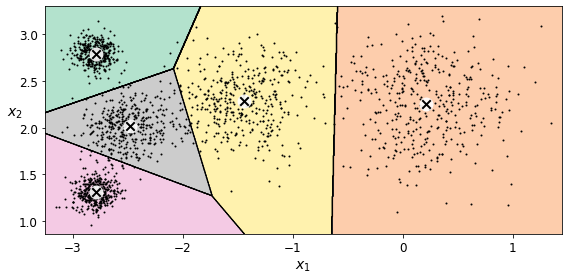

In [26]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not Bad! Some of the instances near the edges were probably initialized to wrong clusters, but overall it looks pretty good.

### Hard Clustering _vs_ Soft Clustering

Rather than arbitarily choosing for the closet cluster to each instance, which is called _hard clustering_, it might be better to measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [27]:
kmeans.transform(X_new)

array([[2.90568117, 0.33171995, 2.87682941, 1.47427824, 2.48349307],
       [5.84912202, 2.80085976, 5.83467069, 4.45469342, 5.48343236],
       [0.29016458, 3.29592492, 1.69564732, 1.7085972 , 1.10475866],
       [1.96296577, 1.23765061, 1.92017428, 0.53219417, 1.48356787]])

This is the Euclidian distance between each instance and each centroid:

In [28]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.90568117, 0.33171995, 2.87682941, 1.47427824, 2.48349307],
       [5.84912202, 2.80085976, 5.83467069, 4.45469342, 5.48343236],
       [0.29016458, 3.29592492, 1.69564732, 1.7085972 , 1.10475866],
       [1.96296577, 1.23765061, 1.92017428, 0.53219417, 1.48356787]])

In [29]:
np.tile(X_new, (1, k)).reshape(-1, k, 2)

array([[[ 0,  2],
        [ 0,  2],
        [ 0,  2],
        [ 0,  2],
        [ 0,  2]],

       [[ 3,  2],
        [ 3,  2],
        [ 3,  2],
        [ 3,  2],
        [ 3,  2]],

       [[-3,  3],
        [-3,  3],
        [-3,  3],
        [-3,  3],
        [-3,  3]],

       [[-1,  2],
        [-1,  2],
        [-1,  2],
        [-1,  2],
        [-1,  2]]])

## K-Means Algorithm

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [30]:
kmeans_iter1 = KMeans(n_clusters=k, init='random', n_init=1,
                     algorithm='full', max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=k, init='random', n_init=1,
                     algorithm='full', max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=k, init='random', n_init=1,
                     algorithm='full', max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

Plotting this:

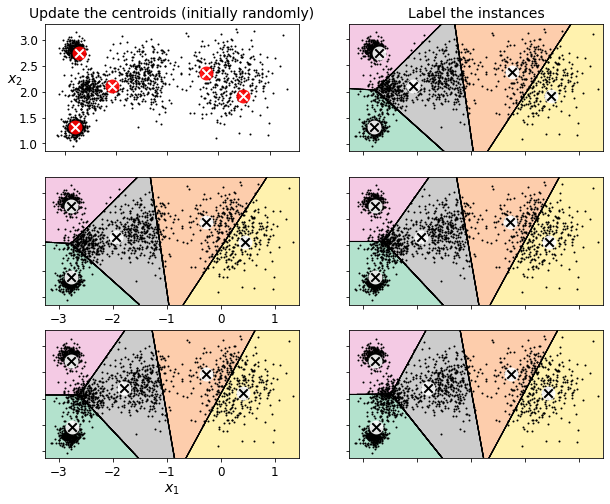

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_ylabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False, show_ylabels=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_xlabels=False, show_ylabels=False)

### K-Means Variability

In [32]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)
    
    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


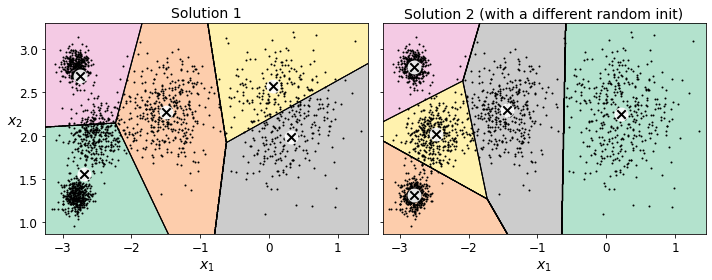

In [33]:
kmeans_rnd_init1 = KMeans(n_clusters=k, init='random', n_init=1,
                         algorithm='full', random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=k, init='random', n_init=1,
                         algorithm='full', random_state=42)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X, 'Solution 1', 'Solution 2 (with a different random init)')
save_fig('kmeans_variability_plot')
plt.show()

### Inertia

To select the best model we will need to evaluate a K-Mean model's performance. But, since it is a unsupervised task, we don't have targets. But, atleast we can measure the distance between each instance and it's centroid. This is the idea behind the K-Means's metric model's **inertia**

In [34]:
kmeans.inertia_

230.1048069394465

Inertia is the sum of squared distances between each training instance and it's closest centroid:

In [35]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2)

230.10480693944606

The `score()` method returns the negative inertia. Why negative? Because a predictor’s `score()` method must always respect Scikit-Learn’s **“greater is better”** rule: if a predictor is better than another, its `score()` method should return a greater score.

In [36]:
kmeans.score(X)

-230.10480693944652

### Multiple Initializations

In [37]:
kmeans_rnd_init1.inertia_

292.0992153392933

In [38]:
kmeans_rnd_init2.inertia_

230.10696288296464

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [39]:
kmeans_rnd_10_inits = KMeans(n_clusters=k, init='random', n_init=10,
                            algorithm='full', random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

230.1048069394465


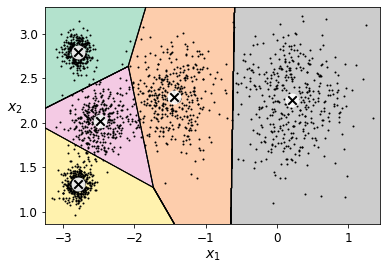

In [40]:
print(kmeans_rnd_10_inits.inertia_)
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

If you happen to know approximately where the centroids should be (e.g., if you ran
another clustering algorithm earlier), then you can set the init hyperparameter to a
NumPy array containing the list of centroids, and set `n_init` to 1 :

In [41]:
good_init = np.array([[0.5, 3], [-2, 3], [-3, 1.5], [-3, 3], [-3, 1]])
kmeans = KMeans(n_clusters=k, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

230.1048069394465

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [42]:
%timeit -n 50 KMeans(algorithm='elkan', random_state=42).fit(X)

47.7 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [43]:
%timeit -n 50 KMeans(algorithm='full', random_state=42).fit(X)

43.6 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


We can't see significant difference in this case, as dataset is fairly small

### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [42]:
from sklearn.cluster import MiniBatchKMeans

In [43]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [44]:
minibatch_kmeans.inertia_

230.7270133085829

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [45]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist['data'], mnist['target'], random_state=42)

If the dataset does not fit in memory, the simplest option is to use the memmap class. Let's write it to `memmap`:

In [47]:
filename = 'my_mnist.data'
X_mm = np.memmap(filename, dtype='float32', mode = 'write', shape=X_train.shape)

In [48]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(n_clusters=5, random_state=42)

Mini-batch K-Means is much faster than regular K-Means

In [49]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

61.3 ms ± 8.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

14.9 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's much faster! However, its performance is often lower (higher inertia), and it keeps degrading as k increases. Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [51]:
from timeit import timeit

In [52]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

29/100

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], 'r--', label='K-Means')
plt.plot(range(1, 101), inertias[:, 1], 'b.-', label='Mini-batch K-Means')
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], 'r--', label='K-means')
plt.plot(range(1, 101), times[:, 1], 'b.-', label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Training time(seconds)', fontsize=14)
plt.axis([1, 100, 0, 10])

save_fig('minibatch_kmeans_vs_kmeans')
plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a greator or lower value than 5?

Saving figure bad_n_clusters_plot


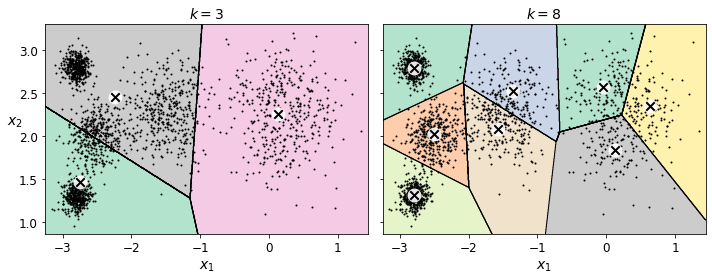

In [53]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_3, kmeans_8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch! These models don't loook great. What about their inertias?

In [54]:
kmeans_3.inertia_

699.3426316948005

In [55]:
kmeans_8.inertia_

137.9304311743377

The inertia is not a good performance metric when trying to choose k because it keeps getting lower as we increase k. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be.

In [56]:
# Plotting inertia as a function of k

In [57]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


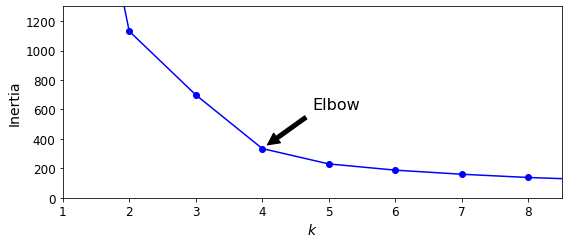

In [58]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

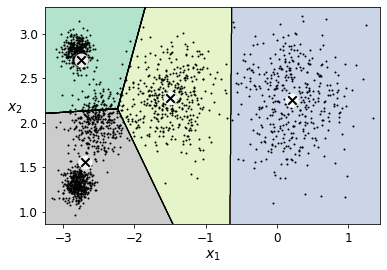

In [59]:
plot_decision_boundaries(kmeans_per_k[3], X)
plt.show()

**Silhouette score [Metric for K-Means]**

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot silhouette score as a function of $k$:

In [60]:
from sklearn.metrics import silhouette_score

In [61]:
silhouette_score(X, kmeans.labels_)

0.6245736865681233

In [62]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


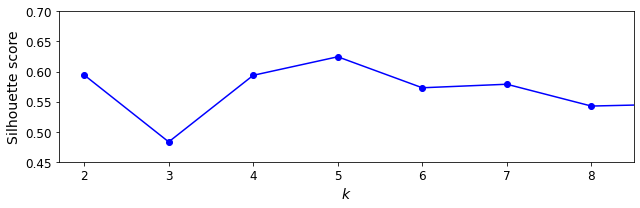

In [63]:
plt.figure(figsize=(9, 3))
plt.plot(range(2, 10), silhouette_scores, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.7, 8.5, 0.45, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, how this metric score confirms that k=5 is a very good choice, while underlining the fact that k=4 is a quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

Saving figure silhouette_analysis_plot


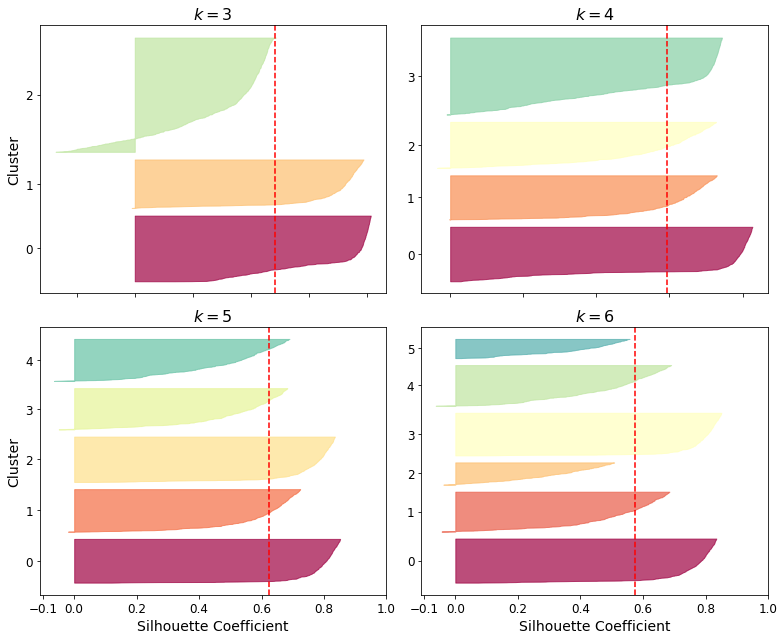

In [64]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
#         print(coeffs.shape)
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

In [65]:
np.r_?

### Limitations of K-Means

In [66]:
# Let's make three elipsoidal clusters of different dimensions, densities, and orientations
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
X.shape

(1250, 2)

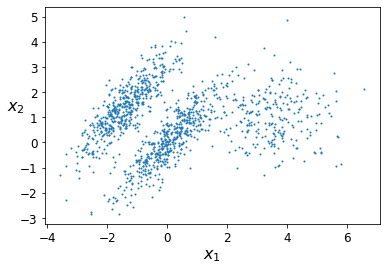

In [67]:
plot_clusters(X)

In [68]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


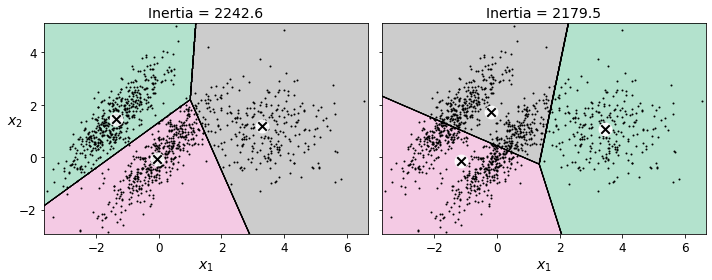

In [69]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig('bad_kmeans_plot')
plt.show()

## Using clustering for image segmentation

In [70]:
# Download the lady bug image
import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print('Downloading', filename)
url = DOWNLOAD_ROOT + 'images/unsupervised_learning/' + filename
urllib.request.urlretrieve(url, os.path.join(IMAGES_PATH, filename))

('./images/ladybug.png', <http.client.HTTPMessage at 0x7f38b228da90>)

In [71]:
from matplotlib.image import imread
image = imread(os.path.join(IMAGES_PATH, filename))
image.shape

(533, 800, 3)

In [72]:
from sklearn.cluster import KMeans

In [73]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [74]:
kmeans.cluster_centers_

array([[0.98363745, 0.9359338 , 0.02574807],
       [0.02289337, 0.11064845, 0.00578197],
       [0.21914783, 0.38675755, 0.05800817],
       [0.75775605, 0.21225454, 0.0445884 ],
       [0.09990625, 0.2542204 , 0.01693457],
       [0.6126616 , 0.63010883, 0.38751987],
       [0.37212682, 0.5235918 , 0.15730345],
       [0.8845907 , 0.7256049 , 0.03442055]], dtype=float32)

In [75]:
kmeans.labels_
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [76]:
kmeans.cluster_centers_[kmeans.labels_]

array([[0.02289337, 0.11064845, 0.00578197],
       [0.02289337, 0.11064845, 0.00578197],
       [0.02289337, 0.11064845, 0.00578197],
       ...,
       [0.09990625, 0.2542204 , 0.01693457],
       [0.02289337, 0.11064845, 0.00578197],
       [0.02289337, 0.11064845, 0.00578197]], dtype=float32)

In [77]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


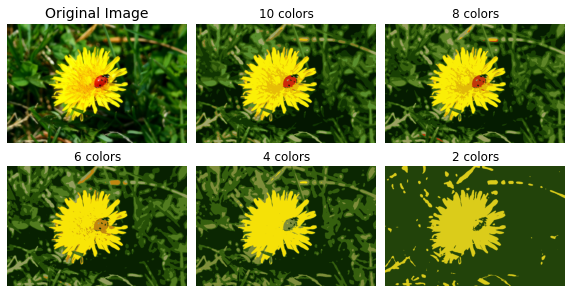

In [78]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title('Original Image', fontsize=14)
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

## Using clustering for preprocessing

In [127]:
from sklearn.datasets import load_digits

In [128]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

## Clustering for Semi-supervised learning

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labelled instances

In [130]:
n_labeled = 50

In [131]:
from sklearn.linear_model import LogisticRegression

In [132]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It is much less than earlier offcourse. Let's first, cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images.

In [133]:
k = 50

In [134]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

In [135]:
X_representative_digits.shape

(50, 64)

Saving figure representative_images_plot


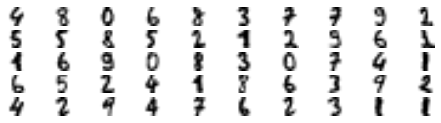

In [136]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap='binary', interpolation='bilinear')
    plt.axis('off')

save_fig('representative_images_plot', tight_layout=False)
plt.show()

In [137]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [138]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1
])

In [139]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

We jumped from an accuracy of 83.3% to 92.2% by training the model on just 50 representative instaces of each cluster.

Let's try by propagating the labels to all the other instances of a clusters:

In [140]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [141]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [142]:
log_reg.score(X_test, y_test)

0.9333333333333333

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [143]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_dist = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = X_cluster_dist > cutoff_dist
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [144]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [145]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [146]:
log_reg.score(X_test, y_test)

0.9355555555555556

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

## DBSCAN

In [147]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

In [148]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [149]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [150]:
dbscan.labels_[:15]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2])

In [151]:
len(dbscan.core_sample_indices_)

808

In [152]:
dbscan.core_sample_indices_[:15]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19])

In [153]:
dbscan.components_[:5]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267]])

In [154]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [155]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [168]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask  = ~(core_mask | anomalies_mask)
#     print(non_core_mask)
    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='*', s=20)
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', marker='x', s=100)
#     plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker='.')
    if show_xlabels:
        plt.xlabel('$x1$', fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel('$x2$', fontsize=14)
    else:
        plt.tick_params(labelleft=False)
    plt.title('eps={:.2f}, min_samples={}'.format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


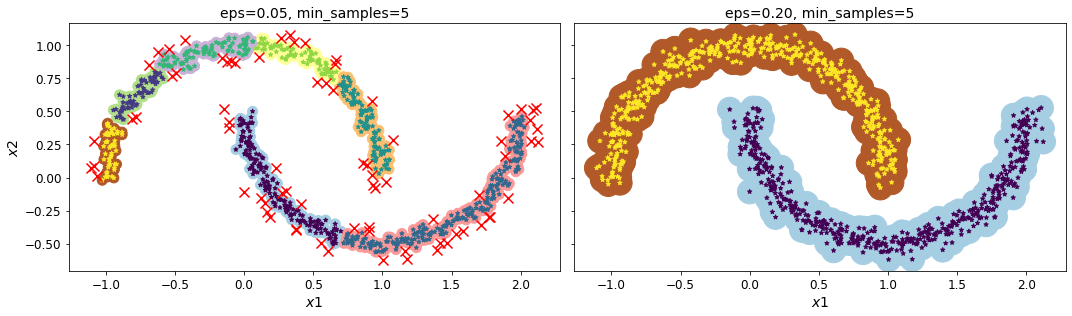

In [169]:
plt.figure(figsize=(15, 4.5))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()